#Disease-gene link prediction

Michael Ying

CPSC 483 final project

Acknowledgements to Kathy Fan, Terence Tam, and Anthony Tzen, whose code I've adapted to test my hypotheses.


# 1) Install and import packages


In [34]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))
print(torch.version.cuda)

PyTorch has version 2.1.0+cu118
11.8


In [35]:
# check link matches pytorch version from above
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html


Import python packages



In [36]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import string
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T

from plotly import graph_objs as go
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
# from sklearn.model_selection import ParameterGrid
from torch_geometric.data import Data, download_url, extract_gz
from torch_geometric.nn import GAE, GCNConv, VGAE, SAGEConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree


In [37]:
# seeds for reproducing results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# 2) Download data.

Download data straight from the SNAP website.

In [38]:
# pick dataset to use
dataset = "AssocMiner" # AssocMiner or Miner
# dataset = "Miner"

# small dataset
if dataset == "AssocMiner":
  url = 'http://snap.stanford.edu/biodata/datasets/10012/files/DG-AssocMiner_miner-disease-gene.tsv.gz'
  extract_gz(download_url(url, '.'), '.')
  data_path = "./DG-AssocMiner_miner-disease-gene.tsv"

# larger dataset
elif dataset == "Miner":
  url = 'https://snap.stanford.edu/biodata/datasets/10020/files/DG-Miner_miner-disease-gene.tsv.gz'
  extract_gz(download_url(url, '.'), '.')
  data_path = "./DG-Miner_miner-disease-gene.tsv"

else:
  print("Error: invalied dataset chosen")


Using existing file DG-AssocMiner_miner-disease-gene.tsv.gz
Extracting ./DG-AssocMiner_miner-disease-gene.tsv.gz


In [39]:
# ----- load in data ----- #
# AssocMiner has column names ["# Disease ID", "Disease Name", "Gene ID"]
# Miner has column names ["# Disease(MESH)", "Gene"] -- careful, mismatch with AssocMiner.
df = pd.read_csv(data_path, sep="\t")
print(df.head(), '\n')


  # Disease ID              Disease Name  Gene ID
0     C0036095  Salivary Gland Neoplasms     1462
1     C0036095  Salivary Gland Neoplasms     1612
2     C0036095  Salivary Gland Neoplasms      182
3     C0036095  Salivary Gland Neoplasms     2011
4     C0036095  Salivary Gland Neoplasms     2019 



Assign each node (disease or gene) to a unique integer index.

*   For the AssocMiner dataset, we have 519 disease nodes indexed 0 through 518, and 7294 gene nodes indexed 519 through 7812.
*   For the full Miner dataset, we have 5663 disease nodes labelled [0, 5662] and 17821 gene nodes [5663, 23483].

The edge index list is a list of pairs (x1, x2), where x1 is the index of the head node and x2 is the index of the tail node.

In [40]:
def load_node_mapping(datafile_path, index_col, offset=0):
  """
  Maps each distinct node to a unique integer index.

  Args: datafile_path : string name of the tsv file containing the graph data
        index_col     : string name of the column containing the nodes of concern
        offset        : amount to shift the generated indexes by
  Returns: a dictionary mapping node name to integer index and its inverse
  """
  df = pd.read_csv(datafile_path, index_col=index_col, sep="\t")
  mapping = {index_id: i + offset for i, index_id in enumerate(df.index.unique())}
  inverse_mapping = {i: index_id for (index_id, i) in mapping.items()}
  return mapping, inverse_mapping

def load_edge_list(datafile_path, src_col, src_mapping, dst_col, dst_mapping):
  """
  Given node mappings, returns edge list (tensor) in terms of node integer indices.

  Args: datafile_path : string name of the tsv file containing the graph data
        src_col       : string name of the column corresponding to source nodes
        src_mapping   : mapping from source node name to integer index
  Returns: the mapping from node name to integer index
  """
  df = pd.read_csv(datafile_path, sep="\t")
  src_nodes = [src_mapping[index] for index in df[src_col]]
  dst_nodes = [dst_mapping[index] for index in df[dst_col]]
  edge_index = torch.tensor([src_nodes, dst_nodes])
  return edge_index

def initialize_data(datafile_path, num_features=20):
  """
  Given a tsv file specifying disease-gene interactions, index the nodes and
  construct a Data object.
  """
  # manual column name filtering
  if dataset == "AssocMiner":
    dz_col, gene_col = "# Disease ID", "Gene ID" # AssocMiner
  elif dataset == "Miner":
    dz_col, gene_col = "# Disease(MESH)", "Gene" # Miner
  else:
    print("invalid datafile_path") # error catch
    return

  # Get disease node mapping and gene node mapping.
  dz_mapping, inverse_dz_mapping = load_node_mapping(datafile_path, dz_col, offset=0)
  n_dz = len(dz_mapping)  # number of disease nodes = offset for gene node indexing
  gene_mapping, inverse_gene_mapping = load_node_mapping(datafile_path, gene_col, offset=n_dz)

  # Get edge index in terms of the integer indices assigned to the nodes.
  edge_index = load_edge_list(
      datafile_path, dz_col, dz_mapping, gene_col, gene_mapping)

  # Add the reverse direction (aka make it a undirected graph)
  rev_edge_index = load_edge_list(
      datafile_path, gene_col, gene_mapping, dz_col, dz_mapping)

  # Construct a Data object.
  data = Data()
  data.num_nodes = len(dz_mapping) + len(gene_mapping)
  data.edge_index = torch.cat((edge_index, rev_edge_index), dim=1)
  data.x = torch.ones((data.num_nodes, num_features)) # default features of nodes, can be changed later

  return data, gene_mapping, inverse_gene_mapping, dz_mapping, inverse_dz_mapping

Construct our Data object from our dataset

In [41]:
# Read data and construct Data object.
data_object, gene_mapping, inverse_gene_mapping, dz_mapping, inverse_dz_mapping = initialize_data(data_path)
n_genes = len(gene_mapping)
n_dz = len(dz_mapping)
print(data_object)
print("Number of genes:", n_genes)
print("Number of diseases:", n_dz)

Data(num_nodes=7813, edge_index=[2, 42714], x=[7813, 20])
Number of genes: 7294
Number of diseases: 519


Optional graph augmentations via changing the data object. This can be done in the data-processing step (as shown here), or inside of the encoder class (implementation shown later).

In [42]:
# ----- augmentation: add in a global disease and gene node ----- #
do_augment = False

if do_augment:
    new_data_object, gene_mapping, inverse_gene_mapping, dz_mapping, inverse_dz_mapping = initialize_data(data_path)
    n_genes = len(gene_mapping)
    n_dz = len(dz_mapping)
    n_nodes = new_data_object.num_nodes

    global_dz_node_id = n_nodes
    global_gene_node_id = n_nodes + 1

    # create and add new edges
    new_dz_edges = torch.tensor([[global_dz_node_id]*n_dz, [i for i in range(n_dz)]])
    new_dz_edges_reverse = torch.tensor([[i for i in range(n_dz)], [global_dz_node_id]*n_dz]) # add reverse of edges since undirected
    new_gene_edges = torch.tensor([[global_gene_node_id]*n_genes, [i for i in range(n_dz, n_nodes)]])
    new_gene_edges_reverse = torch.tensor([[i for i in range(n_dz, n_nodes)], [global_gene_node_id]*n_genes]) # reverse
    new_edges = torch.cat((new_dz_edges, new_dz_edges_reverse, new_gene_edges, new_gene_edges_reverse), dim=1)

    new_data_object_global_edge_index = torch.cat((new_data_object.edge_index, new_edges), dim=1)

    # add node features; disease features first
    n_ones = new_data_object.x.shape[1]
    new_features = torch.ones(2, n_ones)  # default is vector of ones
    new_data_object_global_x = torch.cat((new_data_object.x, new_features), dim=0)

    # add to counter
    new_data_object_global_num_nodes = new_data_object.num_nodes + 2

    # usable data object with global node inserted
    data_object_global = Data()
    data_object_global.num_nodes = new_data_object_global_num_nodes
    data_object_global.edge_index = new_data_object_global_edge_index
    data_object_global.x = new_data_object_global_x

    print(data_object_global)

Exploratory data analysis

In [43]:
# Recall, dz_mapping maps dz_ids to node_index.
reverse_dz_mapping = {j: i for i,j in dz_mapping.items()}
reverse_gene_mapping = {j: i for i,j in gene_mapping.items()}

degrees = degree(data_object.edge_index[0]).numpy()
sorted_degrees_i = np.argsort(-1* degrees)

print("Disease Nodes of highest degree")
top_k = 10
num_dz_nodes = 0
for i in sorted_degrees_i:
  if i < 519:   # Disease nodes have node indeces < 519
    node_id = reverse_dz_mapping[i]
    node_description = df[df["# Disease ID"] == node_id]["Disease Name"].drop_duplicates().iloc[0]
    node_degree = degrees[i]
    print("node_index=" + str(i), "node_degree=" + str(int(node_degree)),
          node_id, node_description)
    num_dz_nodes += 1
    if num_dz_nodes >= top_k:
      break

print("\nGene Nodes of highest degree")
num_gene_nodes = 0
for i in sorted_degrees_i:
  if i >= 519:
    node_id = reverse_gene_mapping[i]
    node_degree = degrees[i]
    print("node_index=" + str(i), "node_degree=" + str(int(node_degree)), node_id)
    num_gene_nodes += 1
    if num_gene_nodes >= top_k:
      break

Disease Nodes of highest degree
node_index=119 node_degree=485 C0033578 Prostatic Neoplasms
node_index=472 node_degree=450 C0017661 IGA Glomerulonephritis
node_index=280 node_degree=433 C1458155 Mammary Neoplasms
node_index=461 node_degree=298 C0028754 Obesity
node_index=184 node_degree=293 C0031117 Peripheral Neuropathy
node_index=479 node_degree=284 C0038356 Stomach Neoplasms
node_index=161 node_degree=280 C0036341 Schizophrenia
node_index=131 node_degree=254 C0004352 Autistic Disorder
node_index=91 node_degree=232 C0009404 Colorectal Neoplasms
node_index=155 node_degree=222 C2239176 Liver carcinoma

Gene Nodes of highest degree
node_index=654 node_degree=115 7124
node_index=577 node_degree=96 6648
node_index=714 node_degree=83 5743
node_index=622 node_degree=79 3569
node_index=656 node_degree=68 7157
node_index=620 node_degree=61 3553
node_index=691 node_degree=58 7040
node_index=972 node_degree=56 4524
node_index=658 node_degree=50 7422
node_index=866 node_degree=49 3162



# 3) Add node features (if any) and construct train/valid/test splits.

We try two types of features for nodes to examine effectiveness.

1. Identical node embeddings full of 1s.

In [44]:
NUM_FEATURES = 20

data_object.x = torch.ones((data_object.num_nodes, NUM_FEATURES))
print("Using dummy embeddings as initial node features.")
print(f"Number of features: {NUM_FEATURES}")

Using dummy embeddings as initial node features.
Number of features: 20


2. Structural node embeddings

In [45]:
# ----- process structural embeddings for nodes - pathway motifs ----- #
G_motifs_data_url = "https://snap.stanford.edu/biodata/datasets/10011/files/G-MtfPathways_gene-motifs.csv.gz"
extract_gz(download_url(G_motifs_data_url, '.'), '.')

D_motifs_data_url = "https://snap.stanford.edu/biodata/datasets/10010/files/D-MtfPathways_disease-motifs.csv.gz"
extract_gz(download_url(D_motifs_data_url, '.'), '.')

G_motifs_data_path = "./G-MtfPathways_gene-motifs.csv"
D_motifs_data_path = "./D-MtfPathways_disease-motifs.csv"

G_motifs_data_raw = pd.read_csv(G_motifs_data_path)
D_motifs_data_raw = pd.read_csv(D_motifs_data_path)

Extracting ./G-MtfPathways_gene-motifs.csv.gz
Extracting ./D-MtfPathways_disease-motifs.csv.gz


In [46]:
# ----- create structural features ----- #
n_ones = 20 # have some ones features for genes/diseases without features
run_structural = False

# this dataset uses the same Gene ID's as AssocMiner, but not Miner
if run_structural and dataset == "AssocMiner":
    G_motifs_data = G_motifs_data_raw.drop(['Orbit Signature'], axis=1)

    # normalize G's data since values are integers and get very big
    G_num_cols = [col for col in G_motifs_data.columns if col != "Gene ID"]
    for col in G_num_cols:
      G_motifs_data[col] = (G_motifs_data[col] - G_motifs_data[col].min()) / (G_motifs_data[col].max() - G_motifs_data[col].min())

    # column name processing
    G_motifs_data.columns = ["Gene ID"] + [f"gene_feature_{i}" for i in range(1,72+1)]
    D_motifs_data = D_motifs_data_raw.drop(['Disease Name', 'P-values for each orbit'], axis=1)
    D_motifs_data.columns = ["Disease ID"] + [f"disease_feature_{i}" for i in range(1,72+1)]

    # create column map_index used to help merge dataframes together
    G_motifs_data["map_index"] = G_motifs_data["Gene ID"].map(gene_mapping)
    D_motifs_data["map_index"] = D_motifs_data["Disease ID"].map(dz_mapping)

    G_motifs_data = G_motifs_data.dropna(axis=0) # unmatched Na's are dropped; the ones left are matched ones
    D_motifs_data = D_motifs_data.dropna(axis=0)

    # check if data points are dropped
    # print(G_motifs_data.shape)
    # print(D_motifs_data.shape)

    # combine motif data into feature vectors for nodes
    n_nodes = data_object.num_nodes
    feature_df = pd.DataFrame(1, index=np.arange(n_nodes), columns=np.arange(n_ones))
    feature_df["temp_index"] = feature_df.index

    feature_df = pd.merge(feature_df, G_motifs_data, left_on="temp_index", right_on="map_index", how="left")
    feature_df = feature_df.drop(['Gene ID', 'map_index'], axis=1)
    feature_df = pd.merge(feature_df, D_motifs_data, left_on="temp_index", right_on="map_index", how="left")
    feature_df = feature_df.drop(['Disease ID', 'map_index', "temp_index"], axis=1)

    feature_df = feature_df.fillna(0) # genes do not have diseases features, and vice versa

    # assign as new node features
    feature_np = feature_df.to_numpy()
    data_object.x = torch.from_numpy(feature_np).float()

    # udpated for the conv network
    NUM_FEATURES = feature_df.shape[1]


Construct the dataset splits for the selected dataset. We use a train - validation - test dataset split of 15% - 5% - 20%.

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
# ----- transform to create train/val/test datasets ----- #
transform = T.Compose([
    # T.NormalizeFeatures(), # sets torch.ones --> torch.zeros
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.15, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
])

In [49]:
# ----- create dataset ----- #
train_dataset, val_dataset, test_dataset = transform(data_object)
print("Train Data:\n", train_dataset)
print("Validation Data:\n", val_dataset)
print("Test Data:\n", test_dataset)

Train Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 20], pos_edge_label=[17087], pos_edge_label_index=[2, 17087], neg_edge_label=[17087], neg_edge_label_index=[2, 17087])
Validation Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 20], pos_edge_label=[1067], pos_edge_label_index=[2, 1067], neg_edge_label=[1067], neg_edge_label_index=[2, 1067])
Test Data:
 Data(num_nodes=7813, edge_index=[2, 36308], x=[7813, 20], pos_edge_label=[3203], pos_edge_label_index=[2, 3203], neg_edge_label=[3203], neg_edge_label_index=[2, 3203])


In [50]:
# ----- implementation of global node model (external to the class) ----- #
# train_dataset_global, val_dataset_global, test_dataset_global = transform(data_object_global)
# print("Train Data:\n", train_dataset_global)
# print("Validation Data:\n", val_dataset_global)
# print("Test Data:\n", test_dataset_global)


# 4) Analysis and Visualization helpers [borrowed]
In this section, we provide the code for generating some useful graphs to understand how our model behaves before, during, and after training.

In [51]:
def get_mapping():
  data_path = "./DG-AssocMiner_miner-disease-gene.tsv"
  df = pd.read_csv(data_path, index_col="Disease Name", sep="\t")
  disease_mapping = [index_id for index_id in enumerate(df.index.unique())]
  df = pd.read_csv(data_path, index_col="Gene ID", sep="\t")
  gene_mapping = [index_id[1] for index_id in enumerate(df.index.unique())]
  mapping = disease_mapping + gene_mapping
  return mapping

def visualize_tsne_embeddings(model, data, title, perplexity=30.0,
                              labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with t-SNE.

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
        perplexity, t-SNE hyperparameter for perplexity
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)
  ax1, ax2 = zip(*TSNE(n_components=2, learning_rate='auto', perplexity=perplexity,
                       init='random').fit_transform(z.detach().cpu().numpy()))

  fig = px.scatter(x=ax1, y=ax2, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()],
                   title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=ax1[i], y=ax2[i],
                         text=str(i), showarrow=False)
  fig.show()

def visualize_pca_embeddings(model, data, title, labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with PCA (components=2)

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)

  pca = PCA(n_components=2)
  components = pca.fit_transform(z.detach().cpu().numpy())
  fig = px.scatter(components, x=0, y=1, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()], title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=components[:,0][i], y=components[:,1][i],
                         text=str(i), showarrow=False)
  fig.show()

In [52]:
def plot_roc_curve(model, data):
  """Visualizes ROC curve of model predictions

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
  """
  model.eval()

  x = data.x
  z = model.encode(x, data.edge_index)

  pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
  neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
  preds = torch.cat([pos_preds, neg_preds], dim=0)
  preds = preds.detach().cpu().numpy()

  labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
  labels = labels.detach().cpu().numpy()
  fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

  # Using J-statistic: https://en.wikipedia.org/wiki/Youden%27s_J_statistic
  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  print('Best Threshold=%f' % (best_thresh))

  roc_auc = metrics.roc_auc_score(labels, preds)

  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--') # diagonal roc curve of a random classifier
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc = 'lower right')
  plt.title('ROC curve for model predictions')
  plt.show()

In [53]:
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap):
  """Plots evolution of loss and metrics during training

  Args: losses, test_auc, test_ap, train_auc, and train_ap should be lists
    outputted by the training process.
  """
  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  plt.show()

In [54]:
def get_edge_dot_products(data, model, num_dz_nodes=519):
  """
  A pair of nodes (u,v) is predicted to be connected with an edge if the dot
  product between the learned embeddings of u and v is high. This function
  computes and returns the dot product of all pairs of (dz_node, gene_node).

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    dot_products, a numpy 2D array of shape (num_dz_nodes, num_gene_nodes)
      containing the dot product between each (dz_node, gene_node) pair.
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z)
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=519):
  """
  Ranks all potential edges as predicted by the model.

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    ranked_edge_list, a full edge list ranked by the likelihood of the edge
      being a positive edge, in decreasing order
    ranked_dot_products, a list of the dot products of each edge's node
      embeddings, ranked in decreasing order
  """
  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


# 5) Initialize and train the GAE model.

In this section, we will create and train the Graph Autoencoder (GAE) model using the GAE module provided by PyG. We use the default inner product decoder and focus on testing a few different encoder classes.

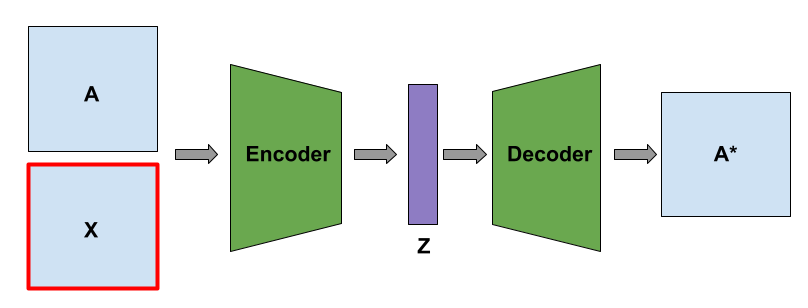

In [55]:
#@title Model & Training Configuration

HIDDEN_SIZE = 200  #@param {type: "integer"}

OUT_CHANNELS = 20  #@param {type: "integer"}

EPOCHS =   60      #@param {type: "integer"}

In [56]:
# ----- classic 2-layer GCN ----- #
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=True) # cache
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1).float()
        output = self.conv2(x_temp2, edge_index).float()

        return output

# initialize GAE model
gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.4))
gae_model = gae_model.to(device)

In [57]:
# ----- classic 2-layer GCN with two global nodes inserted ----- #
# insertion and processing of two new global nodes are built into this class
# so that inputs remain the same as that of the GCNEncoder
class GlobalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout, n_dz=519):
        super(GlobalGCNEncoder, self).__init__()

        self.n_dz = n_dz        # number of disease nodes; rest assumed to be genes

        self.conv1 = GCNConv(in_channels, hidden_size, cached=True)
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True)
        self.dropout = nn.Dropout(dropout)

    # augments the nodes and edges with
    def augment_inputs(self, x, edge_index):
        n_nodes = x.shape[0]
        n_dz = self.n_dz
        n_gene = n_nodes - n_dz

        # augment x
        global_node_features = torch.ones(2, x.shape[1]).float().to(device)
        x_aug = torch.cat((x, global_node_features), dim=0)

        # augment edge_index
        global_dz_id = n_nodes # next index
        global_gene_id = global_dz_id + 1

        new_dz_edges = torch.tensor([[global_dz_id]*n_dz, [i for i in range(n_dz)]]).to(device)
        new_dz_edges_reverse = torch.tensor([[i for i in range(n_dz)], [global_dz_id]*n_dz]).to(device)
        new_gene_edges = torch.tensor([[global_gene_id]*n_gene, [i for i in range(n_dz, n_nodes)]]).to(device)
        new_gene_edges_reverse = torch.tensor([[i for i in range(n_dz, n_nodes)], [global_gene_id]*n_gene]).to(device)
        edges_aug = torch.cat((edge_index, new_dz_edges, new_dz_edges_reverse, new_gene_edges, new_gene_edges_reverse), dim=1)

        return x_aug, edges_aug

    def forward(self, x, edge_index):
        # augment data within the class
        x, edge_index = self.augment_inputs(x, edge_index)

        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1).float()
        output = self.conv2(x_temp2, edge_index).float()

        return output

# initialize model
global_gae_model = GAE(GlobalGCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.4, 519)) # hardcoded
global_gae_model = global_gae_model.to(device)

In [58]:
# ----- 2-layer GraphSAGE model ----- #
class SAGEConvEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(SAGEConvEncoder, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = SAGEConv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)


sage_gae_model = GAE(SAGEConvEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.2))
sage_gae_model = sage_gae_model.to(device)

In [59]:
# ----- helper functions for SkipGNN implementation ----- #
def normalize_adj(adj):
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def edge_index_to_sparse_mx(edge_index):
    """ Converts an edge index tensor into a sparse adjacency matrix """
    edge_index_cpu = edge_index.cpu()

    ones = np.ones(edge_index_cpu.shape[1])

    rows = np.array(edge_index_cpu[0])
    cols = np.array(edge_index_cpu[1])

    matrix_cpu = sp.coo_matrix((ones, (rows, cols)))
    matrix = matrix_cpu # cpu issues?

    return matrix

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """ [borrowed] Convert a scipy sparse matrix to a torch sparse tensor """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def square_edge_index(edge_index):
    """ Takes in edge index as input, squares the adjacency matrix, and returns the resulting edge index """
    # sparsify
    adj_matrix = edge_index_to_sparse_mx(edge_index)

    # square matrix, apply sign() to convert all values to 0/1
    adj2_matrix = adj_matrix.dot(adj_matrix)
    adj2_matrix = adj2_matrix.sign()

    # obtain new edge indices
    sparse_tensor = sparse_mx_to_torch_sparse_tensor(adj2_matrix)
    skip_edge_index = sparse_tensor.coalesce().indices()

    return skip_edge_index

In [60]:
# SkipGNN encoder, from Huang et al. 2020
# https://www.nature.com/articles/s41598-020-77766-9

class SkipEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(SkipEncoder, self).__init__()

        self.orig_conv1 = GCNConv(in_channels, hidden_size)
        self.orig_conv2 = GCNConv(hidden_size, out_channels)

        self.orig_conv1_skip = GCNConv(hidden_size, hidden_size)

        self.skip_conv1 = GCNConv(in_channels, hidden_size)

        self.skip_conv1_orig = GCNConv(in_channels, hidden_size)
        self.skip_conv2_orig = GCNConv(hidden_size, out_channels)

        self.dropout = nn.Dropout(dropout)
        # self.dropout = dropout


    def forward(self, x, edge_index):
        # x_temp1 = self.conv1(x, edge_index).relu()
        # x_temp2 = self.dropout(x_temp1)
        # return self.conv2(x_temp2, edge_index)

        orig_edge_index = edge_index.to(device)

        # compute skip index
        skip_edge_index = square_edge_index(orig_edge_index) # function from below
        skip_edge_index = skip_edge_index.to(device)

        # first layer
        orig_x = F.relu(self.orig_conv1(x, orig_edge_index) + self.skip_conv1_orig(x, skip_edge_index))
        skip_x = F.relu(self.skip_conv1(x, skip_edge_index) + self.orig_conv1_skip(orig_x, orig_edge_index))

        # dropout
        # orig_x = F.dropout(orig_x, self.dropout, training = self.training)
        # skip_x = F.dropout(skip_x, self.dropout, training = self.training)

        orig_x = self.dropout(orig_x, training = self.training)
        skip_x = self.dropout(skip_x, training = self.training)

        # second layer with sum aggregation
        output = self.orig_conv2(orig_x, orig_edge_index) + self.skip_conv2_orig(skip_x, skip_edge_index)

        return output


skip_gae_model = GAE(SkipEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.4))
skip_gae_model = skip_gae_model.to(device)

The training function uses the default reconstruction loss from the GAE class, which is a binary cross entropy loss applicable to our binary link prediction task.

In [61]:
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index.to(device), train_data.neg_edge_label_index.to(device))
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)


#### Model Training

In [71]:
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

EPOCHS = 100 # change for testing

# temporary - model and optimizer selection
gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.4))
gae_model = gae_model.to(device)
# global_gae_model = GAE(GlobalGCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.4, 519)) # hardcoded
# global_gae_model = global_gae_model.to(device)
# sage_gae_model = GAE(SAGEConvEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.1))
# sage_gae_model = sage_gae_model.to(device)
# skip_gae_model = GAE(SkipEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.4))
# skip_gae_model = skip_gae_model.to(device)

optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01) # GCN
# optimizer = torch.optim.Adam(sage_gae_model.parameters(), lr=0.01) # SAGE
# optimizer = torch.optim.Adam(global_gae_model.parameters(), lr=0.01) # Global
# optimizer = torch.optim.Adam(skip_gae_model.parameters(), lr=0.0001) # Global

for epoch in range(1, EPOCHS + 1):
    loss = gae_train(train_dataset, gae_model, optimizer) # GCN
    # loss = gae_train(train_dataset, sage_gae_model, optimizer) # SAGE
    # loss = gae_train(train_dataset, global_gae_model, optimizer) # Global
    # loss = gae_train(train_dataset, skip_gae_model, optimizer) # Skip

    losses.append(loss)

    auc, ap = gae_test(test_dataset, gae_model) # GCN
    # auc, ap = gae_test(test_dataset, sage_gae_model) # SAGE
    # auc, ap = gae_test(test_dataset, global_gae_model) # Global
    # auc, ap = gae_test(test_dataset, skip_gae_model) # Skip

    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(train_dataset, gae_model) # GCN
    # train_auc, train_ap = gae_test(train_dataset, sage_gae_model) # SAGE
    # train_auc, train_ap = gae_test(train_dataset, global_gae_model) # Global
    # train_auc, train_ap = gae_test(train_dataset, skip_gae_model) # Skip

    train_aucs.append(train_auc)
    train_aps.append(train_ap)

    print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, test AUC: 0.9443, test AP: 0.9417, train AUC: 0.9472, train AP: 0.9419, loss:1.9628
Epoch: 002, test AUC: 0.9451, test AP: 0.9425, train AUC: 0.9481, train AP: 0.9426, loss:2.5250
Epoch: 003, test AUC: 0.9439, test AP: 0.9415, train AUC: 0.9468, train AP: 0.9415, loss:1.3441
Epoch: 004, test AUC: 0.9423, test AP: 0.9403, train AUC: 0.9452, train AP: 0.9403, loss:1.2066
Epoch: 005, test AUC: 0.9415, test AP: 0.9396, train AUC: 0.9444, train AP: 0.9397, loss:1.3917
Epoch: 006, test AUC: 0.9407, test AP: 0.9390, train AUC: 0.9435, train AP: 0.9390, loss:1.3277
Epoch: 007, test AUC: 0.9399, test AP: 0.9384, train AUC: 0.9427, train AP: 0.9383, loss:1.2483
Epoch: 008, test AUC: 0.9395, test AP: 0.9381, train AUC: 0.9423, train AP: 0.9379, loss:1.2015
Epoch: 009, test AUC: 0.9389, test AP: 0.9376, train AUC: 0.9417, train AP: 0.9374, loss:1.2070
Epoch: 010, test AUC: 0.9394, test AP: 0.9380, train AUC: 0.9422, train AP: 0.9379, loss:1.2084
Epoch: 011, test AUC: 0.9401, test AP: 0

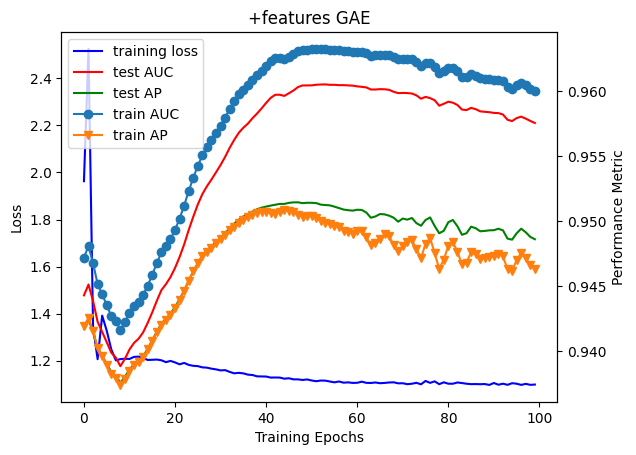

In [72]:
plot_training_stats('+features GAE', losses, test_auc, test_ap, train_aucs, train_aps)

Best Threshold=0.589421


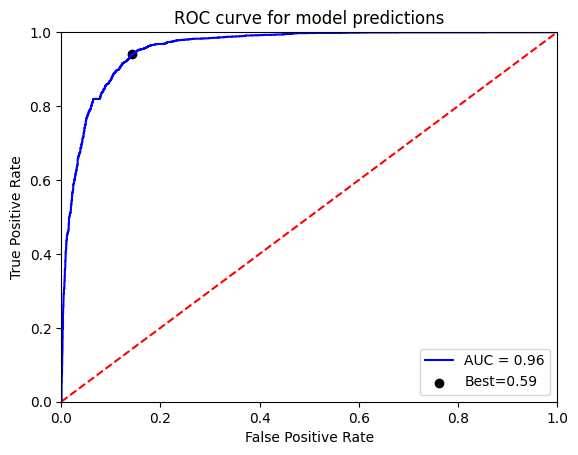

In [73]:
plot_roc_curve(gae_model, test_dataset)

Finally, we can visualize the embeddings again -- this time, with the trained model.

In [65]:
visualize_tsne_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    perplexity=5, labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

In [66]:
visualize_pca_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    labeled=True)#, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])